# Relationship between Critical Temperature and other features
- It follows an evaluation of the results looking for:
    - the *coefficients* of the Linear Regression model
    - https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [41]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from utils.Combinations import Combination
from utils.Search import grid_search

from utils.Custom_Steps import HighCorrFeaturesRemover
from sklearn.pipeline import Pipeline

In [42]:
plt.style.use("seaborn-v0_8")

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "outputs/"

RANDOM_STATE = 42

---
---
## Data Load

In [43]:
df = pd.concat(
    [
        pd.read_csv(DATA_FOLDER + "formula_train.csv").drop(columns=["critical_temp"]),
        pd.read_csv(DATA_FOLDER + "train.csv"),
    ],
    axis=1,
)

# Remove "material" feature (as explained in '0_DataExploration.ipynb')
df = df.drop(columns="material")

print("Shapes of Properties+Formula df: ", df.shape)

Shapes of Properties+Formula df:  (17010, 168)


---
---
## Split

In [44]:
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

X_train = train.drop(columns=["critical_temp"])
y_train = train[["critical_temp"]]

X_test = test.drop(columns=["critical_temp"])
y_test = test[["critical_temp"]]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13608, 167), (3402, 167), (13608, 1), (3402, 1))

---
---
## Linear Regression

In [45]:
estimator_tag = "linear_regression"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "minmax + linear_regression",
            Pipeline([("minmax", preprocessing.MinMaxScaler()), ("linear_regression", LinearRegression())]),
            {},
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

features_coefs_lr = [
    (feature, coef) for feature, coef in zip(model.named_steps["minmax"].get_feature_names_out(), model[-1].coef_)
]
features_coefs_lr.sort(key=lambda x: abs(x[1]), reverse=True)
for feature, coef in features_coefs_lr:
    print(f"{feature}: {coef}")


Combination 1/1  |  minmax + linear_regression
  ==> R2: 0.7538253028800118	MSE: 280.10712800561987
wtd_mean_atomic_radius: 419.08747697025257
wtd_gmean_atomic_radius: -370.19551670851797
wtd_mean_atomic_mass: -257.6455502743734
wtd_mean_ThermalConductivity: 203.71039708392675
mean_fie: -201.54514675128763
Ba: 197.12315446683004
mean_atomic_mass: 195.53723106874168
wtd_mean_FusionHeat: -193.0351102197787
std_ElectronAffinity: 173.01747192890542
gmean_fie: 168.42865645281307
Si: -157.69957278232687
entropy_Valence: 154.95216940029405
wtd_gmean_atomic_mass: 150.1996350978299
wtd_entropy_Valence: -148.3098213120003
wtd_gmean_FusionHeat: 145.7751572677686
wtd_gmean_ElectronAffinity: -141.84139487816938
wtd_gmean_ThermalConductivity: -134.01129874019455
mean_FusionHeat: 132.77999112282816
mean_Density: -129.71772929728263
wtd_entropy_fie: 124.63048377924963
wtd_mean_ElectronAffinity: 114.2350674735829
range_ElectronAffinity: -111.7167240551215
mean_atomic_radius: -107.53743112157568
wtd_me

---
## Random Forest


In [46]:
estimator_tag = "random_forest"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "high_corr_features_remover + lmax + minmax + random_forest",
            Pipeline(
                [
                    ("high_corr_features_remover", HighCorrFeaturesRemover()),
                    ("lmax", preprocessing.Normalizer(norm="max")),
                    ("minmax", preprocessing.MinMaxScaler()),
                    ("random_forest", RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "random_forest__max_samples": [0.66],
                "random_forest__criterion": ["squared_error"],
                "random_forest__n_estimators": [200],
                "random_forest__max_depth": [25],
                "random_forest__max_features": [0.6],
                "high_corr_features_remover__corr_threshold": [0.99],
                "random_forest__ccp_alpha": [0],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)
print()

features_importances_rf = [
    (feature, coef)
    for feature, coef in zip(model.named_steps["lmax"].feature_names_in_, model[-1].feature_importances_)
]
features_importances_rf.sort(key=lambda x: x[1], reverse=True)
for feature, importance in features_importances_rf:
    print(f"{feature}: {importance}")

print()
from sklearn.inspection import permutation_importance


features_importances_rf_perm = permutation_importance(
    model[-1],
    model[:-1].transform(X_test),
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
).importances_mean

features_importances_rf_perm = [
    (feature, coef) for feature, coef in zip(model.named_steps["lmax"].feature_names_in_, features_importances_rf_perm)
]
features_importances_rf_perm.sort(key=lambda x: x[1], reverse=True)
for feature, importance in features_importances_rf_perm:
    print(f"{feature}: {importance}")


Combination 1/1  |  high_corr_features_remover + lmax + minmax + random_forest
  ==> R2: 0.9278190011481937	MSE: 82.13034288857776

Cu: 0.40128736112104557
wtd_mean_Valence: 0.13746372121778358
O: 0.06814059821510966
Ca: 0.040683588521082524
wtd_std_Valence: 0.0312931368304155
gmean_Density: 0.028967801921893983
range_ThermalConductivity: 0.026227996995112135
Ba: 0.015613670200181042
wtd_std_ThermalConductivity: 0.010239959935866412
wtd_entropy_Density: 0.009723345903608575
mean_Valence: 0.007566817627255545
wtd_gmean_ElectronAffinity: 0.007533481157400473
wtd_range_atomic_mass: 0.006641653268010702
wtd_mean_ThermalConductivity: 0.006278185016465449
wtd_std_Density: 0.005721991132687731
Zn: 0.005582582283291278
std_atomic_mass: 0.005305513965471753
wtd_gmean_Density: 0.005235344414189955
wtd_gmean_ThermalConductivity: 0.005220591480720512
wtd_entropy_atomic_mass: 0.0051499652765590554
wtd_range_Valence: 0.005098312982208861
Fe: 0.0048973000272701465
range_fie: 0.004588271656961245
wtd

---
## XGBoost


In [49]:
estimator_tag = "xg_boost"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "xg_boost",
            Pipeline(
                [
                    ("xg_boost", XGBRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "xg_boost__n_estimators": [450],
                "xg_boost__learning_rate": [0.15],
                "xg_boost__max_depth": [6],
                "xg_boost__min_child_weight": [3],
                "xg_boost__gamma": [0.5],
                "xg_boost__subsample": [1.0],
                "xg_boost__colsample_bytree": [1.0],
                "xg_boost__reg_lambda": [1.0],
                "xg_boost__reg_alpha": [0.1],
                "xg_boost__tree_method": ["auto"],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

features_importances_xgb = [
    (feature, coef) for feature, coef in zip(model[-1].get_booster().feature_names, model[-1].feature_importances_)
]
features_importances_xgb.sort(key=lambda x: abs(x[1]), reverse=True)
for feature, importance in features_importances_xgb:
    print(f"{feature}: {importance}")


print()
from sklearn.inspection import permutation_importance


features_importances_xgb_perm = permutation_importance(
    model[-1],
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
).importances_mean

features_importances_xgb_perm = [
    (feature, coef) for feature, coef in zip(model[-1].get_booster().feature_names, features_importances_xgb_perm)
]
features_importances_xgb_perm.sort(key=lambda x: x[1], reverse=True)
for feature, importance in features_importances_xgb_perm:
    print(f"{feature}: {importance}")


Combination 1/1  |  xg_boost
  ==> R2: 0.9313694294022581	MSE: 78.09052777731449
Cu: 0.508277177810669
gmean_Valence: 0.05776175856590271
Ba: 0.057193391025066376
range_ThermalConductivity: 0.039747048169374466
Ca: 0.03341061994433403
Zn: 0.018026133999228477
gmean_Density: 0.017502853646874428
range_atomic_radius: 0.013057701289653778
wtd_gmean_Valence: 0.010219337418675423
wtd_mean_Valence: 0.009299146011471748
std_Density: 0.009016276337206364
entropy_Density: 0.009004734456539154
Pr: 0.008907304145395756
Fe: 0.008896412327885628
Mg: 0.008245640434324741
wtd_gmean_Density: 0.008110301569104195
std_ElectronAffinity: 0.0065546706318855286
std_atomic_mass: 0.0057043274864554405
wtd_std_Valence: 0.005267988424748182
range_Valence: 0.004442466422915459
gmean_atomic_mass: 0.004058206919580698
wtd_mean_ThermalConductivity: 0.003995614591985941
wtd_std_ElectronAffinity: 0.0038449487183243036
Sr: 0.0037776923272758722
std_Valence: 0.0034303260035812855
Nb: 0.003404343267902732
As: 0.0031615

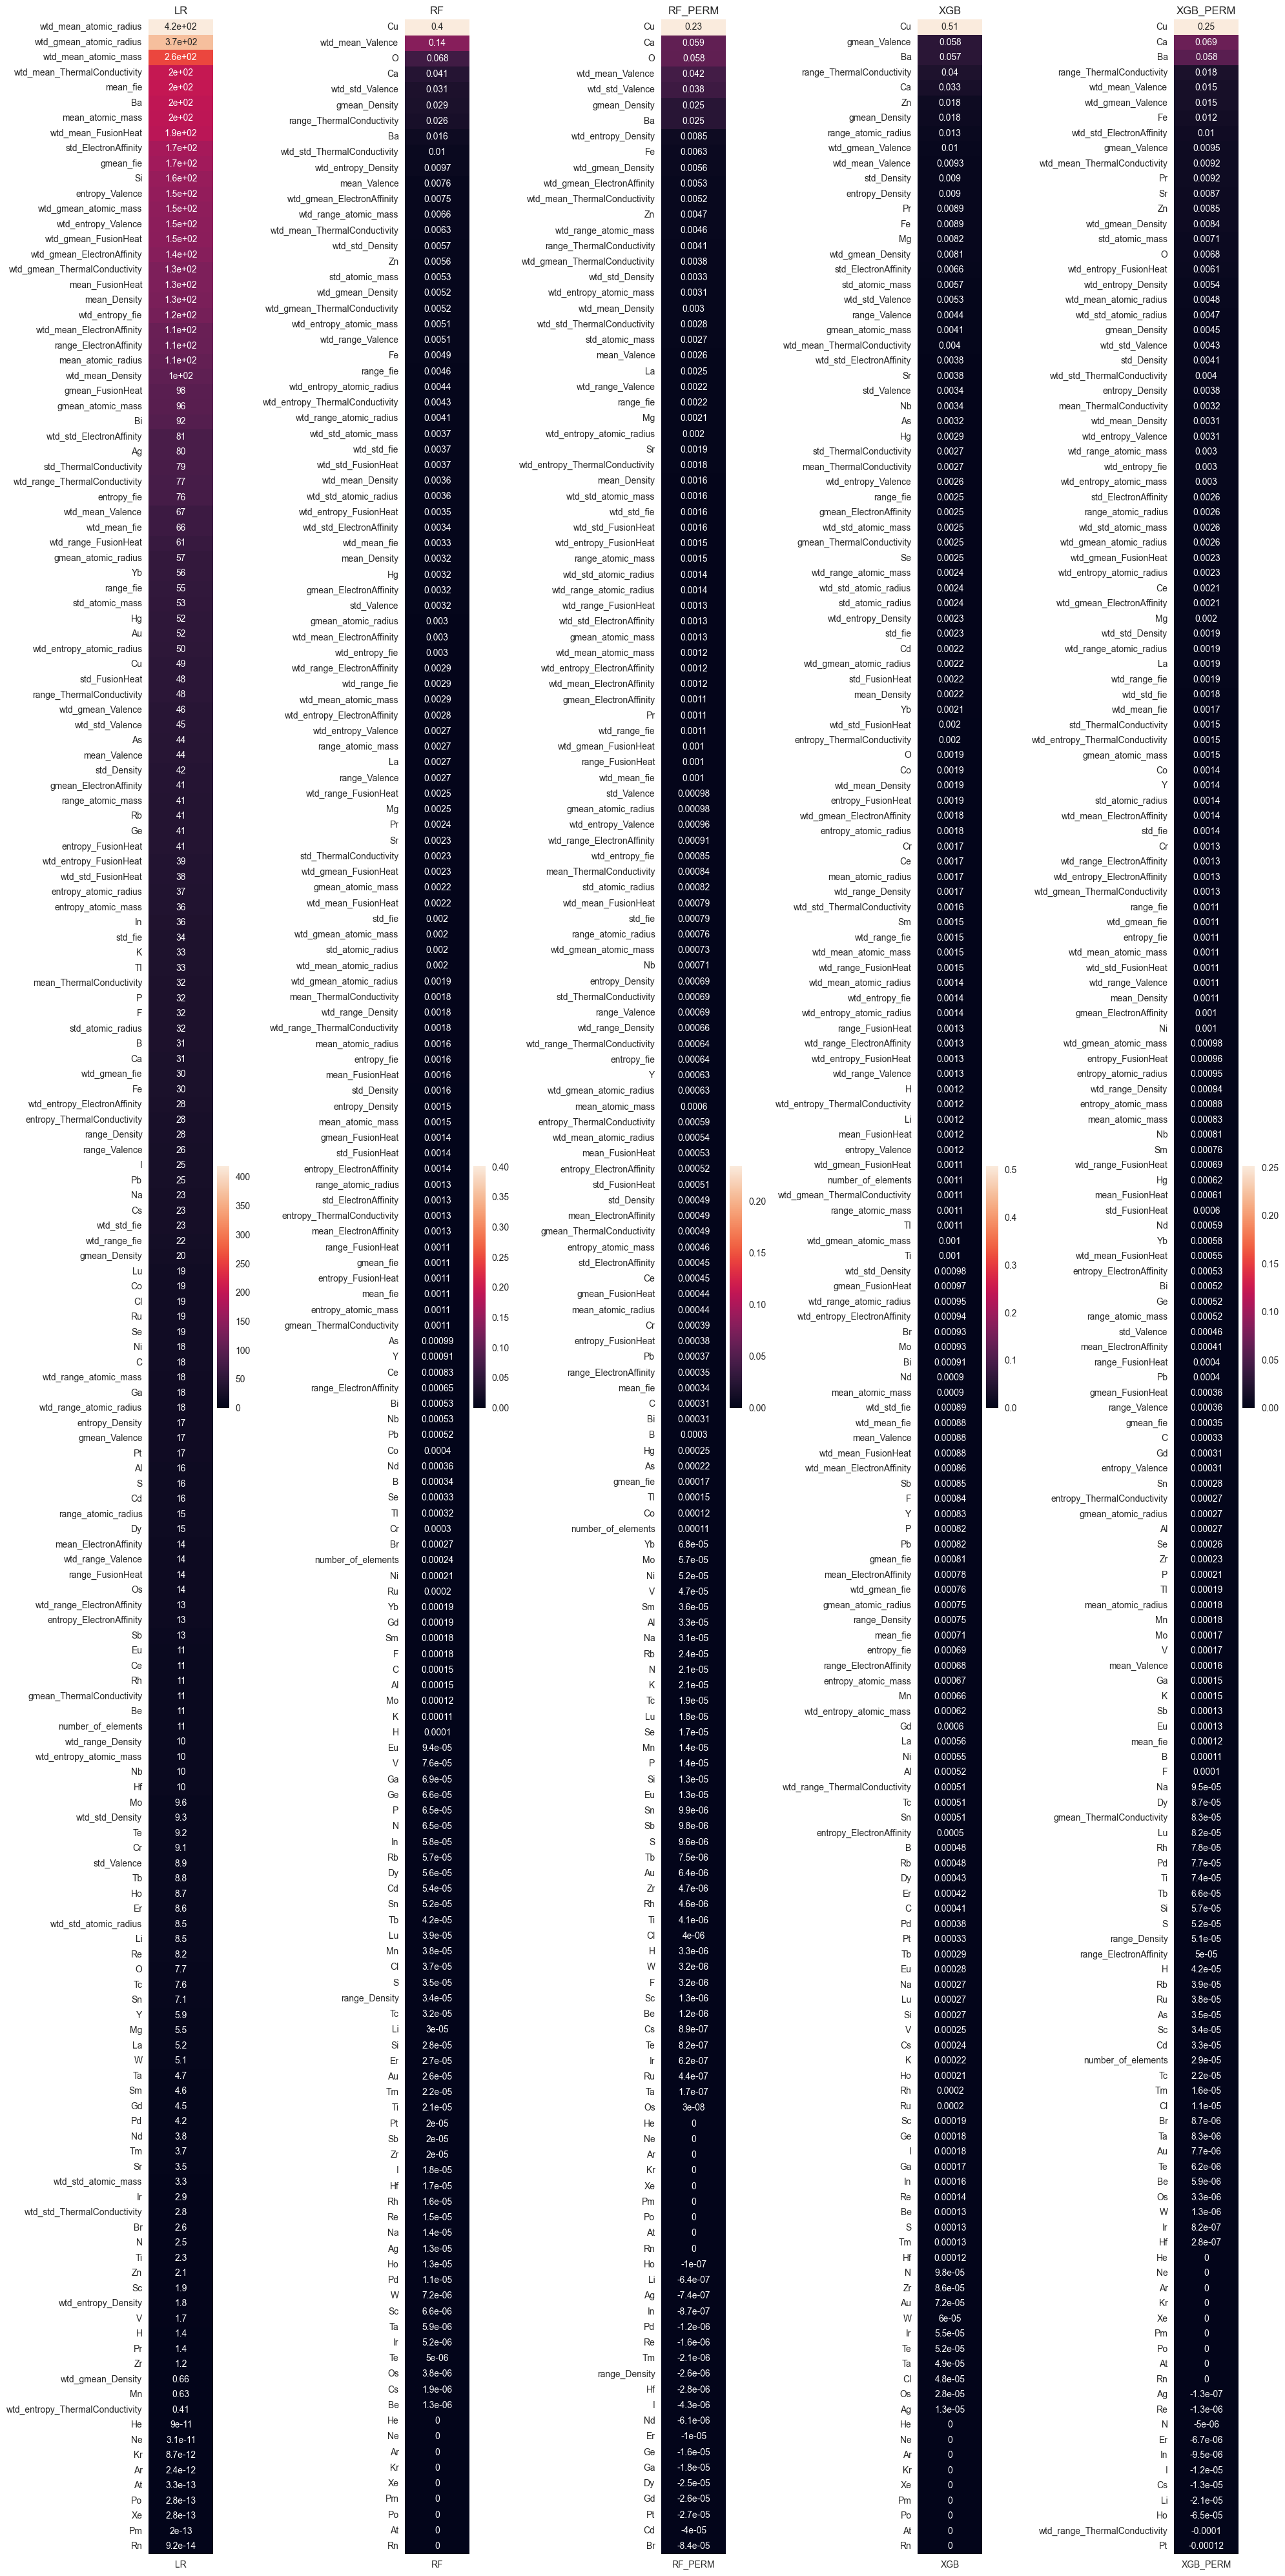

In [52]:
fig = plt.figure(figsize=(20, 40))
gs = gridspec.GridSpec(1, 5)

ax = plt.subplot(gs[0])
df = pd.DataFrame(index=[x[0] for x in features_coefs_lr])
df["LR"] = [abs(x[1]) for x in features_coefs_lr]
sns.heatmap(df[["LR"]], annot=True, ax=ax)
ax.set_title("LR")

ax = plt.subplot(gs[1])
df = pd.DataFrame(index=[x[0] for x in features_importances_rf])
df["RF"] = [x[1] for x in features_importances_rf]
sns.heatmap(df[["RF"]], annot=True, ax=ax)
ax.set_title("RF")

ax = plt.subplot(gs[2])
df = pd.DataFrame(index=[x[0] for x in features_importances_rf_perm])
df["RF_PERM"] = [x[1] for x in features_importances_rf_perm]
sns.heatmap(df[["RF_PERM"]], annot=True, ax=ax)
ax.set_title("RF_PERM")

ax = plt.subplot(gs[3])
df = pd.DataFrame(index=[x[0] for x in features_importances_xgb])
df["XGB"] = [x[1] for x in features_importances_xgb]
sns.heatmap(df[["XGB"]], annot=True, ax=ax)
ax.set_title("XGB")

ax = plt.subplot(gs[4])
df = pd.DataFrame(index=[x[0] for x in features_importances_xgb_perm])
df["XGB_PERM"] = [x[1] for x in features_importances_xgb_perm]
sns.heatmap(df[["XGB_PERM"]], annot=True, ax=ax)
ax.set_title("XGB_PERM")


plt.tight_layout()
plt.show()